# Spectral Decomposition Examples
This notebook demonstrates various ways to use the `spectral_decomposition` package.

## Requirements
- `numpy`
- `scipy`
- `matplotlib`
- `spectral_connectivity` (if you want to use `direct_estimate=True`)


## Example 1: Single Oscillatory Peak (with Empirical PSD)
We'll create a longer signal (60 seconds at 500 Hz) that includes:
- A 1/f background (`aperiodic_exponent=1.5`, `aperiodic_offset=1.0`) 
  (we keep the exponent between 1.0 and 5.0)
- One Gaussian peak at 3 Hz (`freq=3`, `amplitude=10.0`, `sigma=2.0`) 
  (amplitude > 5)
- No extra offset in the time domain (`average_firing_rate=0.0`).
- We'll also do `direct_estimate=True` to estimate an empirical PSD with `spectral_connectivity`.

We'll then plot the time domain signal and the theoretical+empirical PSD decomposition.

/Users/patrick_bloniasz/spectral_decomposition/spectral_decomposition/__init__.py:160: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Combined signal mean: (-27.41934419246365-5.123244576759849e-16j)
Freq range: 0.0 to 249.98333333333332


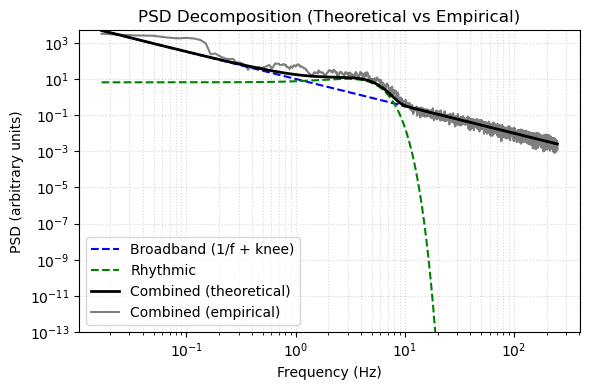

In [1]:
from spectral_decomposition import spectrum

# Example usage
res = spectrum(
    sampling_rate=500,
    duration=60.0,
    aperiodic_exponent=1.5,
    aperiodic_offset=1.0,
    knee=None,
    peaks=[{'freq': 3, 'amplitude': 10.0, 'sigma': 2.0}],
    average_firing_rate=0.0,
    random_state=42,
    direct_estimate=True,
    plot=True
)

# Access time-domain signals
td = res.time_domain
print("Combined signal mean:", td.combined_signal.mean())

# Access freq-domain data
fd = res.frequency_domain
print("Freq range:", fd.frequencies[0], "to", fd.frequencies[-1])

/Users/patrick_bloniasz/miniforge3/envs/spectral-env/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/patrick_bloniasz/miniforge3/envs/spectral-env/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


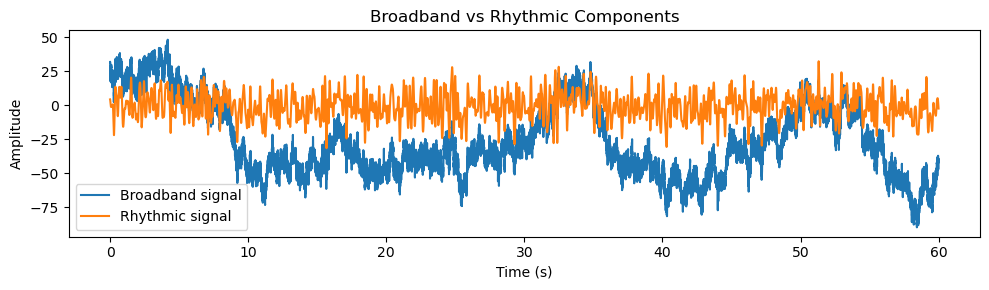

In [2]:
import matplotlib.pyplot as plt
# Example: Plot the broadband and rhythmic signals separately
plt.figure(figsize=(10,3))
plt.plot(td.time, td.broadband_signal, label='Broadband signal')
plt.plot(td.time, td.rhythmic_signal, label='Rhythmic signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Broadband vs Rhythmic Components')
plt.legend()
plt.tight_layout()
plt.show()

## Example 2: Multiple Peaks (No Empirical PSD)
Here, we create a shorter signal with *multiple* Gaussian peaks. We'll skip the built-in plot in the `spectrum()` call and manually visualize the PSD.

Parameters:
- 2 seconds at 500 Hz
- 2 peaks at 10 Hz (`amplitude=50`) and 40 Hz (`amplitude=10`), each >5
- A 1/f background with exponent=1.2, offset=2.0 (within the 1..5 range)
- `direct_estimate=False`

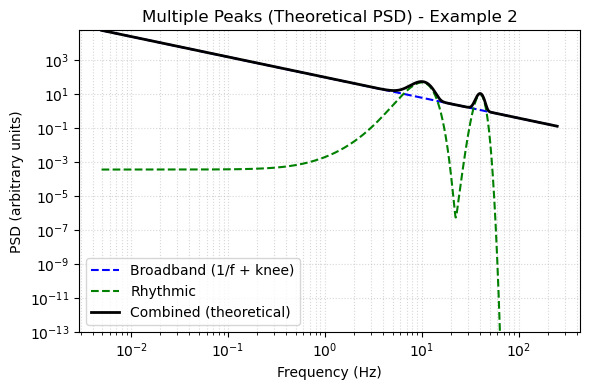

TimeDomainData(n_samples=1000, combined_signal_mean=20.571-0.000j)


In [3]:
from spectral_decomposition.plotting import PSDPlotter

peaks_2 = [
    {'freq':10, 'amplitude':50, 'sigma':2.0},
    {'freq':40, 'amplitude':10, 'sigma':3.0}
]

result2 = spectrum(
    sampling_rate=500,
    duration=2.0,
    aperiodic_exponent=1.2,
    aperiodic_offset=2.0,
    knee=None,
    peaks=peaks_2,
    average_firing_rate=0.0,
    direct_estimate=False,
    plot=False,            # We'll do a custom plot below
    random_state=123
)

freq_dom2 = result2.frequency_domain
plotter = PSDPlotter()
fig = plotter.plot(freq_dom2)
plt.title('Multiple Peaks (Theoretical PSD) - Example 2')
plt.show()

# Also examine the time-domain signals
print(result2.time_domain)

## Example 3: Single Peak with Empirical PSD (direct_estimate=True)
This time, we enable `direct_estimate=True` to use **`spectral_connectivity`** for empirical PSD estimation.

Parameters:
- 60 seconds at 250 Hz
- Single peak at 12 Hz, amplitude=100 (>5)
- A 1/f background: exponent=3.0, offset=1.0 (within [1..5])
- `average_firing_rate=0.0`

If `spectral_connectivity` is not installed, you'll get an ImportError. Notice the rather extreme spectral leakage here. To mitigate this, you will need to account for the dynamical range prior to spectral estimation (e.g., with a filter).

Parameters: {'sampling_rate': 250, 'n_samples': 15000, 'duration': 60.0, 'aperiodic_exponent': 3.0, 'aperiodic_offset': 1.0, 'knee': 0.0, 'peaks': [{'freq': 12, 'amplitude': 100.0, 'sigma': 4}], 'direct_estimate': True, 'average_firing_rate': 0.0, 'random_state': 0}
Frequency Domain Data length: 7500
Empirical PSD shape: (7500,)


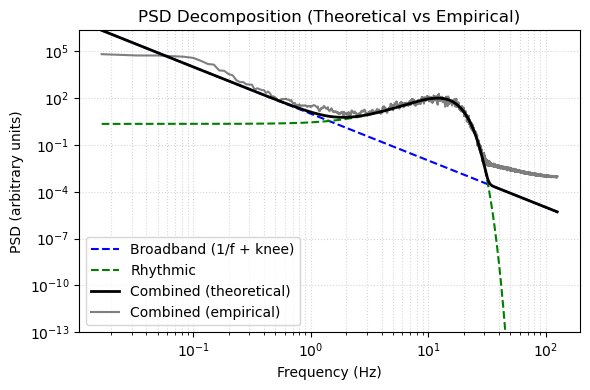

In [4]:
result3 = spectrum(
    sampling_rate=250,
    duration=60.0,
    aperiodic_exponent=3.0,
    aperiodic_offset=1.0,
    knee=None,
    peaks=[{'freq':12, 'amplitude':100.0, 'sigma':4}],
    average_firing_rate=0.0,
    direct_estimate=True,
    plot=True,
    random_state=0
)

print('Parameters:', result3.params)
print('Frequency Domain Data length:', len(result3.frequency_domain))
print('Empirical PSD shape:', (result3.frequency_domain.empirical_spectrum.shape
       if result3.frequency_domain.empirical_spectrum is not None else None))

## Example 4: Varying Aperiodic Exponent and Offset
We’ll create a short signal but systematically adjust the 1/f exponent and offset. This is useful for seeing how the broadband slope changes. We’ll do **two** runs:
1. `aperiodic_exponent=1.0`, `aperiodic_offset=0.5`
2. `aperiodic_exponent=4.0`, `aperiodic_offset=2.0`

Both have the same peak at 15 Hz (amplitude=10.0), no empirical PSD.

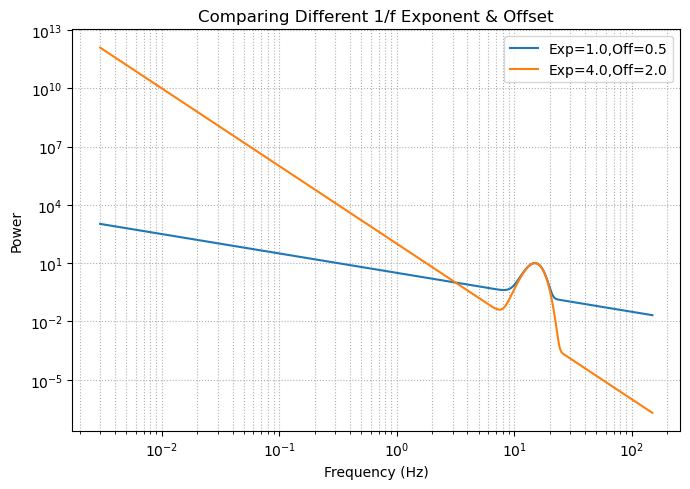

In [5]:
params_list = [
    {'aperiodic_exponent':1.0, 'aperiodic_offset':0.5},
    {'aperiodic_exponent':4.0, 'aperiodic_offset':2.0}
]

import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
for idx, p in enumerate(params_list, start=1):
    res = spectrum(
        sampling_rate=300,
        duration=1.0,
        aperiodic_exponent=p['aperiodic_exponent'],
        aperiodic_offset=p['aperiodic_offset'],
        peaks=[{'freq':15, 'amplitude':10.0, 'sigma':2.0}],
        average_firing_rate=0.0,
        direct_estimate=False,
        plot=False,
        random_state=42 + idx
    )
    freqs = res.frequency_domain.frequencies
    combined_psd = res.frequency_domain.combined_spectrum
    mask = freqs>0
    plt.loglog(freqs[mask], combined_psd[mask], label=f"Exp={p['aperiodic_exponent']},Off={p['aperiodic_offset']}")

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Comparing Different 1/f Exponent & Offset')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()

## Example 5: Looping Over Different Random Seeds
A short demonstration of how you might want to see how the signal changes with different random seeds. The theoretical PSD is the same, but the actual time-domain instantiations (and thus the empirical PSD if used) can differ each run.

We'll do a quick loop from `random_state=0` to `random_state=2`, then plot the time-domain signals on top of each other for comparison.

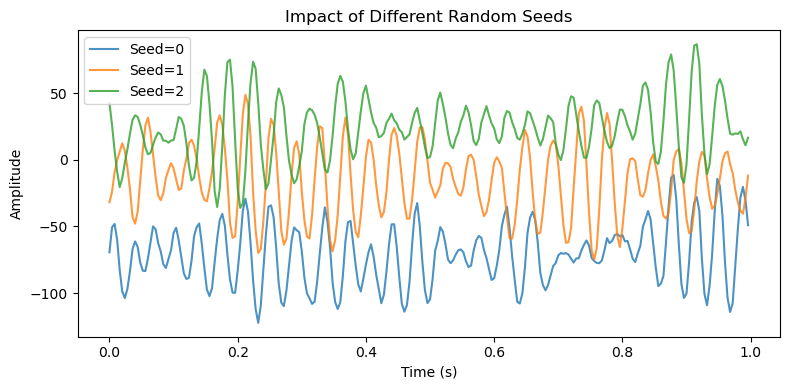

In [6]:
fs = 250
duration = 1.0
exp = 1.5
offs = 1.0
peak_cfg = [{'freq': 25, 'amplitude': 50.0, 'sigma': 2.5}]  # amplitude>5

plt.figure(figsize=(8,4))
for seed_val in [0, 1, 2]:
    result = spectrum(
        sampling_rate=fs,
        duration=duration,
        aperiodic_exponent=exp,
        aperiodic_offset=offs,
        peaks=peak_cfg,
        average_firing_rate=0.0,
        direct_estimate=False,
        plot=False,
        random_state=seed_val
    )
    t = result.time_domain.time
    combined = result.time_domain.combined_signal
    plt.plot(t, combined, label=f'Seed={seed_val}', alpha=0.8)

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Impact of Different Random Seeds')
plt.legend()
plt.tight_layout()
plt.show()

## Summary
We’ve shown how to:
- Run simple simulations with single or multiple peaks
- Use or skip the empirical PSD estimation with `direct_estimate`
- Keep the 1/f exponent between 1.0 and 5.0, and the rhythmic peak amplitude >5
- Compare results across multiple random seeds

Feel free to adapt these snippets for your own research or add more advanced use-cases (e.g., longer time windows, custom peak shapes, etc.).

Happy exploring!